In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt


In [11]:

# Initialize MLflow experiment
mlflow.set_experiment("Skill_Set_Prediction-1")
mlflow.set_tracking_uri("http://localhost:5000")  # Ensure you are using HTTP for the local server




In [12]:
# Load data for KNN and Random Forest
data_knn = pd.read_csv('required_data_v2.csv')  # Adjust file path if necessary
data_rf = pd.read_csv('cleaned_data.csv')  # Adjust file path if necessary


In [13]:

# Prepare data for KNN model
data_knn['Skillset'] = data_knn['Skillset'].str.split(', ')
mlb = MultiLabelBinarizer()
skills_encoded = mlb.fit_transform(data_knn['Skillset'])

X_knn = skills_encoded
y_knn = data_knn['CourseDepartment']
X_knn_train, X_knn_test, y_knn_train, y_knn_test = train_test_split(X_knn, y_knn, test_size=0.2, random_state=42)

# Train KNN model
knn = NearestNeighbors(n_neighbors=3, metric='euclidean')
knn.fit(X_knn_train)

# Function for suggesting the most common skill in the department
def suggest_top_skill(employee_id):
    employee_index = data_knn[data_knn['employeeId'] == employee_id].index[0]
    employee_department = data_knn['CourseDepartment'].iloc[employee_index]
    department_employees = data_knn[data_knn['CourseDepartment'] == employee_department]
    all_skills_in_dept = [skill for skills in department_employees['Skillset'] for skill in skills]
    skill_counts = Counter(all_skills_in_dept)
    current_skills = set(data_knn['Skillset'].iloc[employee_index])
    
    for skill in current_skills:
        if skill in skill_counts:
            del skill_counts[skill]
    
    if skill_counts:
        top_skill, _ = skill_counts.most_common(1)[0]
        return top_skill
    else:
        return "No new skills to suggest in the department."



In [14]:
# Prepare data for Random Forest
data_rf = data_rf.dropna()
X_rf = data_rf[['Skillset', 'CourseDepartment', 'average_score']]
y_rf = data_rf['Suggested Skill']
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

# Preprocessing for Random Forest
numeric_features = ['average_score']
categorical_features = ['Skillset', 'CourseDepartment']

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean'))])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), 
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])


In [15]:

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])



KNN Report Keys: dict_keys(['Cloud', 'Data Engineering', 'Data Science', 'Development', 'accuracy', 'macro avg', 'weighted avg'])


2024/10/28 12:07:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run KNN_Model at: http://localhost:5000/#/experiments/728567108189121125/runs/c4712fdb44e343d5b944f01269a1603a.
2024/10/28 12:07:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/728567108189121125.
d:\Projects\Web Scraping\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2024/10/28 12:07:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run Random_Forest_Model at: http://localhost:5000/#/experiments/728567108189121125/runs/9509260714bc44b2b808982b962dda0a.
2024/10/28 12:07:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/728567108189121125.


KNN Model Accuracy: 0.97
Random Forest Model Accuracy: 0.7391304347826086


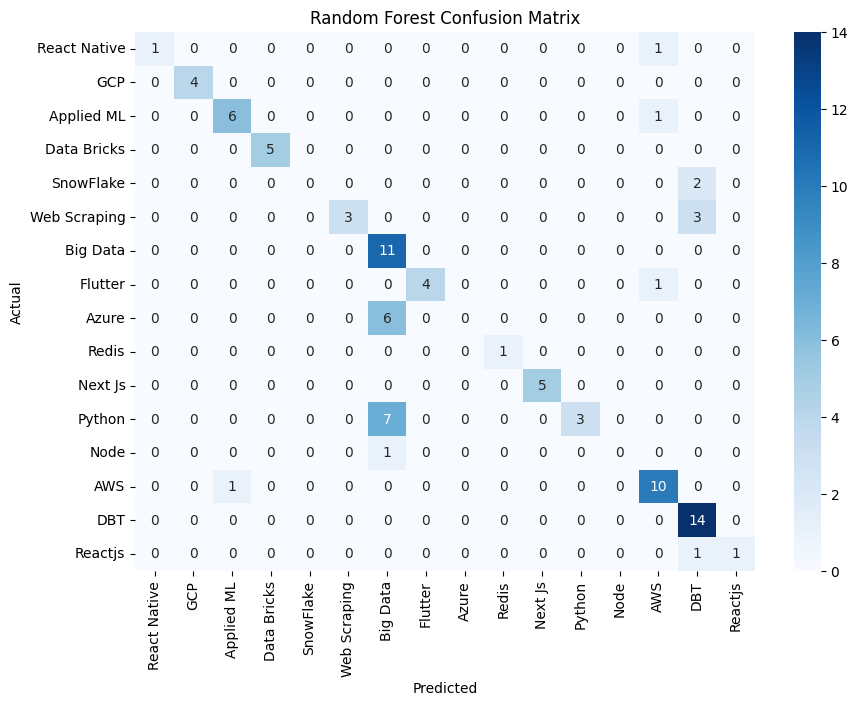

In [16]:
# Log KNN model metrics
with mlflow.start_run(run_name="KNN_Model"):
    # KNN Predictions
    predicted_departments = []
    for i in range(len(X_knn_test)):
        distances, indices = knn.kneighbors([X_knn_test[i]])
        neighbor_departments = y_knn_train.iloc[indices[0]].values
        most_common_department = Counter(neighbor_departments).most_common(1)[0][0]
        predicted_departments.append(most_common_department)

    knn_accuracy = accuracy_score(y_knn_test, predicted_departments)
    mlflow.log_metric("KNN_accuracy", knn_accuracy)

    # Log classification report metrics for KNN
    knn_report = classification_report(y_knn_test, predicted_departments, output_dict=True)
    
    # Check the keys in the report
    print("KNN Report Keys:", knn_report.keys())

    # Use dynamic access for metrics based on available keys
    for key in knn_report.keys():
        if key not in ['accuracy', 'macro avg', 'weighted avg']:
            mlflow.log_metric(f'KNN_recall_{key}', knn_report[key]['recall'])
            mlflow.log_metric(f'KNN_precision_{key}', knn_report[key]['precision'])
            mlflow.log_metric(f'KNN_f1_score_{key}', knn_report[key]['f1-score'])

    # Log additional KNN parameters if needed
    mlflow.log_param("KNN_n_neighbors", 3)  # Example parameter

# Log Random Forest model metrics
with mlflow.start_run(run_name="Random_Forest_Model"):
    rf_pipeline.fit(X_rf_train, y_rf_train)
    y_rf_pred = rf_pipeline.predict(X_rf_test)

    rf_accuracy = accuracy_score(y_rf_test, y_rf_pred)
    rf_precision = precision_score(y_rf_test, y_rf_pred, average='weighted')
    rf_f1 = f1_score(y_rf_test, y_rf_pred, average='weighted')
    rf_recall = recall_score(y_rf_test, y_rf_pred, average='weighted')

    # Log Random Forest metrics
    mlflow.log_metric("RF_accuracy", rf_accuracy)
    mlflow.log_metric("RF_precision", rf_precision)
    mlflow.log_metric("RF_f1_score", rf_f1)
    mlflow.log_metric("RF_recall", rf_recall)
    mlflow.log_param("RF_model_params", rf_pipeline.get_params())

    # Log confusion matrix for Random Forest
    conf_matrix = confusion_matrix(y_rf_test, y_rf_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=data_rf['Suggested Skill'].unique(),
                yticklabels=data_rf['Suggested Skill'].unique())
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Random Forest Confusion Matrix')
    plt.savefig("rf_confusion_matrix.png")
    mlflow.log_artifact("rf_confusion_matrix.png")

    # Apply skill suggestion for a specific employee
    employee_id_to_suggest = 'JMD145'
    suggested_skill = suggest_top_skill(employee_id_to_suggest)
    mlflow.log_param("Suggested_skill_for_employee_JMD145", suggested_skill)

# Display accuracies
print(f"KNN Model Accuracy: {knn_accuracy}")
print(f"Random Forest Model Accuracy: {rf_accuracy}")

In [20]:
model_name = 'KNN Model'
run_id=input('Please type RunID')
model_uri = f'runs:/{run_id}/model_name'
with mlflow.start_run(run_id=run_id):
    mlflow.register_model(model_uri=model_uri, name=model_name)

Successfully registered model 'KNN Model'.
2024/10/28 12:09:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: KNN Model, version 1
Created version '1' of model 'KNN Model'.
2024/10/28 12:09:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run Random_Forest_Model at: http://localhost:5000/#/experiments/728567108189121125/runs/9509260714bc44b2b808982b962dda0a.
2024/10/28 12:09:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/728567108189121125.


In [21]:
current_model_uri = f"models:/{model_name}@challenger"
production_model_name = "Skillet-Recomdation-prod"

client = mlflow.MlflowClient()
client.copy_model_version(src_model_uri=current_model_uri, dst_name=production_model_name)

Successfully registered model 'Skillet-Recomdation-prod'.
Copied version '1' of model 'KNN Model' to version '1' of model 'Skillet-Recomdation-prod'.


<ModelVersion: aliases=[], creation_timestamp=1730097627035, current_stage='None', description='', last_updated_timestamp=1730097627035, name='Skillet-Recomdation-prod', run_id='9509260714bc44b2b808982b962dda0a', run_link='', source='models:/KNN Model/1', status='READY', status_message='', tags={}, user_id='', version='1'>

In [23]:

prod_model_uri = f"models:/{production_model_name}@champion"  # Specify the version

try:
    # Load the model based on its type
    loaded_model = mlflow.sklearn.load_model(prod_model_uri)  # Use the appropriate load function
    
    # Make predictions
    y_pred = loaded_model.predict(X_rf_test)
    print(y_pred[:4])  # Display the first 4 predictions
except Exception as e:
    print("Error loading model or making predictions:", e)


Error loading model or making predictions: The following failures occurred while downloading one or more artifacts from http://localhost:5000/api/2.0/mlflow-artifacts/artifacts/728567108189121125/9509260714bc44b2b808982b962dda0a/artifacts/model_name:
##### File  #####
API request to http://localhost:5000/api/2.0/mlflow-artifacts/artifacts/728567108189121125/9509260714bc44b2b808982b962dda0a/artifacts/model_name/ failed with exception HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow-artifacts/artifacts/728567108189121125/9509260714bc44b2b808982b962dda0a/artifacts/model_name/ (Caused by ResponseError('too many 500 error responses'))
